
part of shape defense
==============================
ALI BORJI


In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [5]:
def load_model(net, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    load_weights = torch.load(model_path, map_location=device)
    net.load_state_dict(load_weights)


In [6]:
from skimage import io, color, feature

def detect_edge(data):
    edge_maps = np.zeros_like(data)
    for idx,img in enumerate(data):
#         import pdb; pdb.set_trace()
        edge_maps[idx,0] = feature.canny(np.array(img[0], dtype=np.float64), sigma = 1)

    return edge_maps
    

In [7]:
def test( model, device, test_loader, epsilon, do_seg = False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        data_orig = torch.clone(data)

        # add noise
        # import pdb; pdb.set_trace()
#         data = add_noise(np.array(np.copy(data)))
        data = torch.Tensor(data.tolist())
        # send to device
        data, target = data.to(device), target.to(device)        

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # MULTIPLY THE ATTACK BY THE MASK; THAT IS REMOVE THE PERTURBATION ON BACKGROUND
        # import pdb; pdb.set_trace()
        if do_seg:
          mask = np.zeros_like(data_orig.detach())
          mask[data_orig.detach() > 0] = 1
          perturbed_data = perturbed_data.cpu().detach()* mask
          perturbed_data = perturbed_data.to(device)


        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [8]:
# from google.colab import drive
# drive.mount('/gdrive')


In [9]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]
import os
epsilons = [0, 8/255, 16/255, 32/255, 64/255, 128/255]
# pretrained_model = "/gdrive/My Drive/Tmp/lenet_mnist_model.pth"
# pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
# path = '/gdrive/My Drive/Tmp/slope_models/'



In [11]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


model = Net().to(device)  # training with slope 1 for now


# training a model first

In [12]:
from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg16().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [15]:
def add_noise(data):
  mask = data > 0

  # noise_data = np.random.rand(data.shape[0], data.shape[1], data.shape[2], data.shape[3])
  noise_data = np.random.rand(*data.shape)  
  noise_data[mask] = data[mask]

  return noise_data

In [19]:
# plt.imshow(d[40,0])
# plt.show()

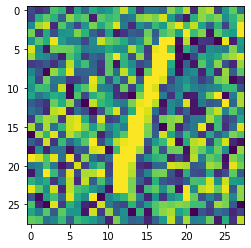

In [20]:
xx = add_noise(data)
plt.imshow(xx[40,0])
plt.show()

In [13]:
# training a model over noise data

EPOCHS = 10
losses = []

optimizer = optim.Adadelta(model.parameters()) #, lr=(1e-3))


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):

        # add noise
        # import pdb; pdb.set_trace()
#         data = add_noise(np.array(np.copy(data)))
#         data = torch.Tensor(data.tolist())
        # send to device
        data, target = data.to(device), target.to(device)        


        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        
        # loss = F.cross_entropy(y_pred, target)
        loss = F.nll_loss(y_pred, target)        
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
    evaluate_y = test_loader.dataset.targets

    evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        


    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))
    

    

 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.420782	 Test Accuracy: 96.6800%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.008380	 Test Accuracy: 98.2900%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.009457	 Test Accuracy: 98.6400%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.000926	 Test Accuracy: 98.8100%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.004874	 Test Accuracy: 98.9500%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.013052	 Test Accuracy: 99.0100%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.008887	 Test Accuracy: 98.8800%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.000341	 Test Accuracy: 98.9900%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.011521	 Test Accuracy: 99.0000%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.055437	 Test Accuracy: 99.0600%


In [14]:
# torch.save(model.state_dict(), 'models/lenet_mnist_model_noise.pth')
torch.save(model.state_dict(), 'models/lenet_mnist_model.pth')

In [216]:
evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
evaluate_x = evaluate_x / 255.0
evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

evaluate_x = add_noise(np.array(evaluate_x)) # [:,None,...])))
evaluate_x = torch.Tensor(evaluate_x)

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(97.6600, dtype=torch.float64)


On clean data

In [218]:
evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
evaluate_x = evaluate_x / 255.0
evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(98.9400, dtype=torch.float64)


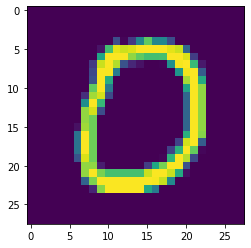

In [219]:
plt.imshow(evaluate_x[10].cpu()); plt.show()

In [ ]:
mask.shape

torch.Size([10000, 28, 28])

# Now perform adversarial attack

In [16]:
test_loader_new = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

model = Net().to(device)  # training with slope 1 for now
orig_model = 'models/lenet_mnist_model.pth'
# use_cuda=True

if os.path.exists(orig_model):
    load_model(model,orig_model)    
    print('model loaded')
model.eval()
accuracies = []
examples = []
accuracies_orig = []
examples_orig = []


# epsilons = [.2, .25, .3]

# Run test for each epsilon
for eps in epsilons:
    do_seg = True
    acc, ex = test(model, device, test_loader_new, eps, do_seg)
    accuracies.append(acc)
    examples.append(ex)

    do_seg = False
    acc_orig, ex_orig = test(model, device, test_loader_new, eps, do_seg)
    accuracies_orig.append(acc_orig)
    examples_orig.append(ex_orig)    

model loaded
Epsilon: 0	Test Accuracy = 9916 / 10000 = 0.9916


KeyboardInterrupt: 

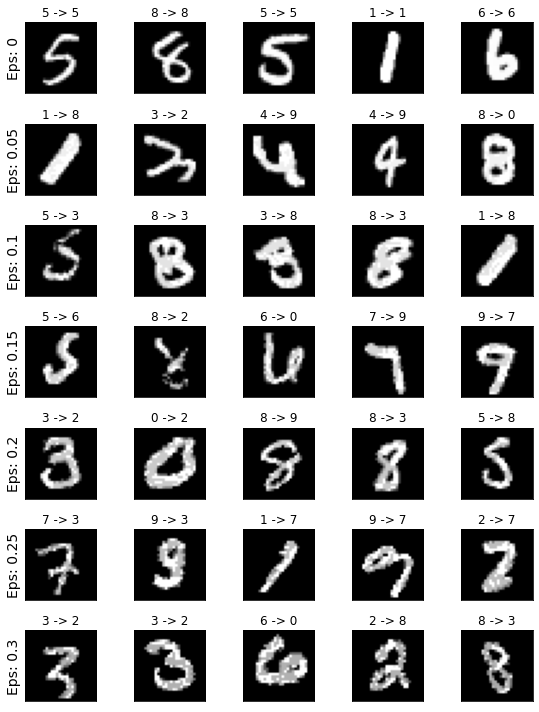

In [237]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

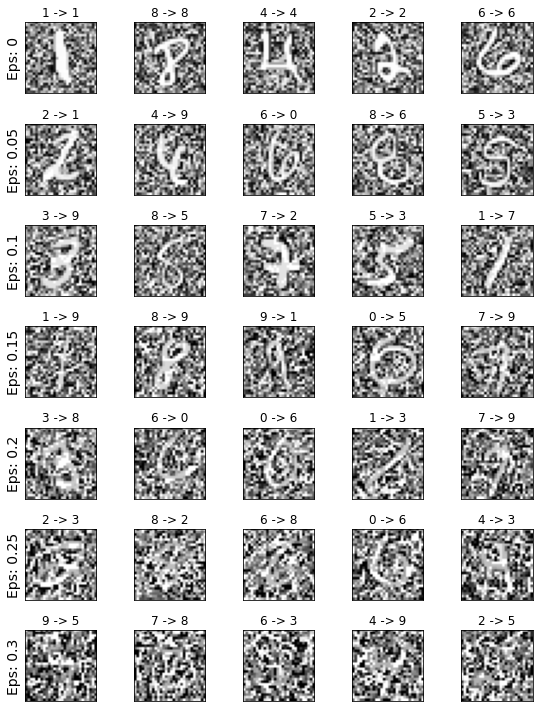

In [238]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_orig[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_orig[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_orig[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [20]:
# plt.figure(figsize=(5,5))
# plt.plot(epsilons, accuracies, "*-")
# plt.plot(epsilons, accuracies_orig, "o-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
# plt.title("Accuracy vs Epsilon")
# plt.xlabel("Epsilon")
# plt.ylabel("Accuracy")
# plt.legend(['with bg masking', 'w/o bg masking'])
# plt.show()

In [16]:
accuracies_clean = [0.981, 0.9634, 0.9391, 0.8973, 0.8509, 0.7917, 0.7217]
accuracies_clean_orig = [0.981, 0.9426, 0.851, 0.6826, 0.4301, 0.2082, 0.0869]

NameError: name 'accuracies' is not defined

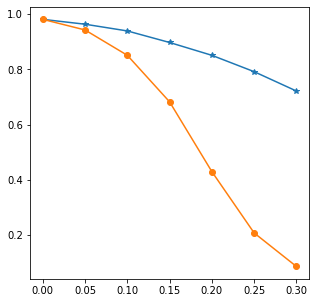

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_clean, "*-")
plt.plot(epsilons, accuracies_clean_orig, "o-")
plt.plot(epsilons, accuracies, "*--")
plt.plot(epsilons, accuracies_orig, "o--")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05)*255)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['with bg masking (clean)', 'w/o bg masking (clean)', 'with bg masking (noise)', 'w/o bg masking (noise)'], loc='center left')
plt.show()